## Week 5 Medium - 定期定額投資回測

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import numpy_financial as npf


import datetime

import tejapi
tejapi.ApiConfig.api_key = "your key"

In [2]:
### 資料撈取 from TEJ API

TW0050 = tejapi.get(
        'TWN/EWPRCD', 
        coid = '0050',
        mdate={'gte':'2016-01-01', 'lte':'2020-12-31'}, 
        opts={'columns': ['mdate','close_adj']}, 
        paginate=True
        )

TW0050['mdate'] = TW0050.loc[:,'mdate'].astype('datetime64[ns]')

### 1. 將資料整理成月資料

In [3]:
TW0050 = TW0050.set_index('mdate')
TW0050

,close_adj
mdate,
2016-01-04,49.8465
2016-01-05,49.4280
2016-01-06,48.9257
2016-01-07,48.0050
2016-01-08,48.0887
...,...
2020-12-25,116.4129
2020-12-28,117.4405
2020-12-29,117.3427


In [4]:
TW0050_monthly = TW0050.resample('MS').first()
TW0050_monthly = TW0050_monthly.append(TW0050.iloc[-1])
TW0050_monthly

,close_adj
mdate,
2016-01-01,49.8465
2016-02-01,49.8465
2016-03-01,51.7717
2016-04-01,53.4877
2016-05-01,50.8510
...,...
2020-09-01,101.1456
2020-10-01,100.8520
2020-11-01,101.1946


### 2. 每月月初投入10000新台幣、期間不領回

In [5]:
TW0050_monthly['每月購買股數']= np.floor(10000 / TW0050_monthly['close_adj'])
TW0050_monthly['每月購買股數'][-1] = 0

In [6]:
TW0050_monthly['累積股數'] = TW0050_monthly['每月購買股數'].cumsum()

In [7]:
TW0050_monthly['累積價值(月)'] = round(TW0050_monthly['累積股數'] * TW0050_monthly['close_adj'],2)

In [8]:
TW0050_monthly['原始價值(月)'] = [10000*i for i in range(len(TW0050_monthly.index))]
TW0050_monthly['原始價值(月)'] = TW0050_monthly['原始價值(月)'].shift(-1)
TW0050_monthly['原始價值(月)'][-1] = TW0050_monthly['原始價值(月)'][-2]

In [9]:
TW0050_monthly['累積報酬(月)'] = round((TW0050_monthly['累積價值(月)']-TW0050_monthly['原始價值(月)'])/TW0050_monthly['原始價值(月)'], 6) +1

In [10]:
TW0050_monthly

,close_adj,每月購買股數,累積股數,累積價值(月),原始價值(月),累積報酬(月)
mdate,,,,,,
2016-01-01,49.8465,200.0,200.0,9969.30,10000.0,0.996930
2016-02-01,49.8465,200.0,400.0,19938.60,20000.0,0.996930
2016-03-01,51.7717,193.0,593.0,30700.62,30000.0,1.023354
2016-04-01,53.4877,186.0,779.0,41666.92,40000.0,1.041673
2016-05-01,50.8510,196.0,975.0,49579.72,50000.0,0.991594
...,...,...,...,...,...,...
2020-09-01,101.1456,98.0,8158.0,825145.80,570000.0,1.447624
2020-10-01,100.8520,99.0,8257.0,832734.96,580000.0,1.435750
2020-11-01,101.1946,98.0,8355.0,845480.88,590000.0,1.433018


### 3. 作圖（累積資產、月報酬）

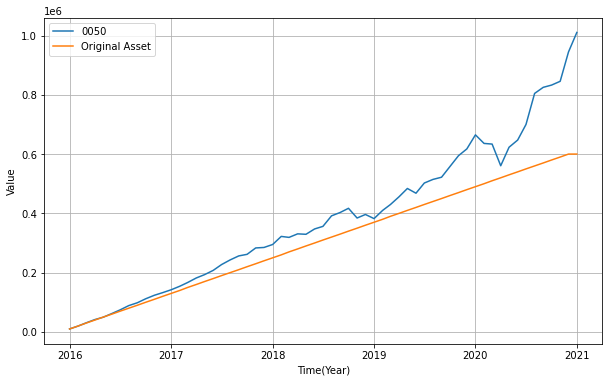

In [11]:
plt.figure(figsize = (10, 6))
plt.plot(TW0050_monthly['累積價值(月)'], lw=1.5, label = '0050')
plt.plot(TW0050_monthly['原始價值(月)'], lw=1.5, label = 'Original Asset')
plt.xlabel('Time(Year)')
plt.ylabel('Value')
plt.legend(loc = 0) 
plt.grid()

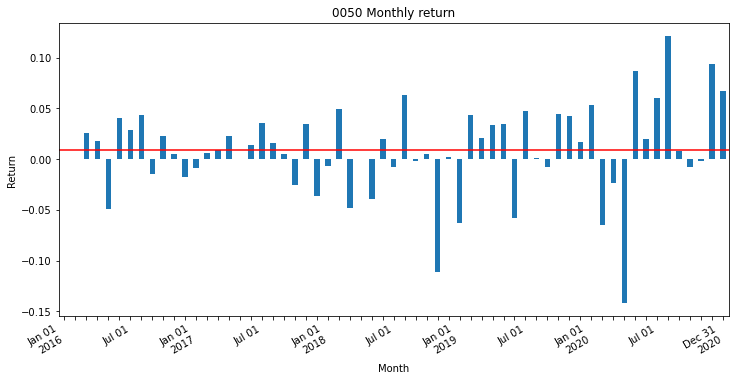

In [12]:
ret = np.log(TW0050_monthly['累積報酬(月)']/TW0050_monthly['累積報酬(月)'].shift(1))

fig, ax = plt.subplots()
ret.plot(kind="bar", figsize=(12,6), stacked=True, ax=ax)

##建立一個空陣列，長度為資料總月份的長度
ticklabels = ['']*len(TW0050_monthly.index)

##每6個月展示出其月份跟日期
ticklabels[::6] = [item.strftime('%b %d') for item in TW0050_monthly.index[::6]]

##每12個月額外展示出年份
ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in TW0050_monthly.index[::12]]

ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()

ax.axhline(ret.mean(), c='r')

plt.xlabel('Month')
plt.ylabel('Return')
plt.title('0050 Monthly return')

plt.show()

### ４. 績效／統計指標

In [13]:
###年報酬
cagr = (TW0050_monthly['累積報酬(月)'][-1]) ** (1/5) -1

###標準差
std = ret.std()*np.sqrt(12)

###夏普比率
sharpe_ratio = (cagr-0.01)/std

###最大回撤
roll_max = TW0050_monthly['累積價值(月)'].cummax()
monthly_dd =TW0050_monthly['累積價值(月)']/roll_max - 1.0
max_dd = monthly_dd.cummin()

In [14]:
pd.DataFrame(columns=['0050'], index=['年化報酬率(%)', '年化標準差(%)', '夏普比率', '期間最大回撤(%)'], 
             data = np.round(np.array([100*cagr, 100*std, sharpe_ratio, 100*max_dd[-1]]),2))

,0050
年化報酬率(%),10.98
年化標準差(%),15.54
夏普比率,0.64
期間最大回撤(%),-15.68


### 附錄：將上述個別的程式碼做成Function

In [15]:
def Dollar_Cost_Averaging(data):    

    data['每月購買股數']= np.floor(10000 / data['close_adj'])
    data['累積股數'] = data['每月購買股數'].cumsum()
    data['累積價值(月)'] = round(data['累積股數'] * data['close_adj'],2)
    data['原始價值(月)'] = [10000*i for i in range(len(data.index))]
    data['原始價值(月)'] = data['原始價值(月)'].shift(-1)
    data['原始價值(月)'][-1] = data['原始價值(月)'][-2]
    data['累積報酬(月)'] = round((data['累積價值(月)']-data['原始價值(月)'])/data['原始價值(月)'], 6) + 1
    
    return data

In [16]:
def Performance(data, ticker):
    
    ret = np.log(data['累積報酬(月)']/data['累積報酬(月)'].shift(1))
    
    cagr = (data['累積報酬(月)'][-1]) ** (1/5) -1
    std = ret.std()*np.sqrt(12)
    sharpe_ratio = (cagr-0.01)/std

    roll_max = data['累積價值(月)'].cummax()
    monthly_dd = data['累積價值(月)']/roll_max - 1.0
    max_dd = monthly_dd.cummin()
    
    df = pd.DataFrame(columns=[ticker], index=['年化報酬率(%)', '年化標準差(%)', '夏普比率', '期間最大回撤(%)'], 
            data = np.round(np.array([100*cagr, 100*std, sharpe_ratio, 100*max_dd[-1]]),2))
    
    return df